# Restaurant Rating Prediction (1–5)

## EDA + 3 Skenario (TF‑IDF → Transformers → Augmentation Saved-to-CSV)

1. **EDA + preprocessing**
2. **Skenario 1 — Baseline TF‑IDF**
   - SVM
   - Naive Bayes
   - Logistic Regression
3. **Skenario 2 — Baseline Transformers**
   - BERT
   - DistilBERT
   - (dengan Early Stopping ringan)
4. **Skenario 3 — Augmentasi**
   - **Generate & simpan** train augmented ke CSV:
     - EDA
     - Modified EDA
     - BERT augmentation (nlpaug)
     - Backtranslation (opsional, berat)


In [2]:
# pip install -U "datasets>=3.1.0" --upgrade


In [3]:
# !pip -q install pandas numpy scikit-learn matplotlib nltk tqdm wordcloud
# !pip -q install torch transformers datasets evaluate accelerate
# !pip -q install nlpaug sentencepiece sacremoses

In [4]:
import os, re, glob, random, shutil, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight

# Optional advanced tools (biar gak NameError kalau kamu mau extend)
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion

import torch

# Reduce TensorFlow/Flax side-effects in Colab/Kaggle
os.environ["TRANSFORMERS_NO_TF"] = "1"
os.environ["TRANSFORMERS_NO_FLAX"] = "1"

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

HAS_GPU = torch.cuda.is_available()
DEVICE = "cuda" if HAS_GPU else "cpu"
print("Device:", DEVICE)
if HAS_GPU:
    try:
        print("GPU:", torch.cuda.get_device_name(0))
    except Exception:
        pass


Device: cuda
GPU: Tesla T4


## 1. Load Dataset


In [ ]:
# DATA_PATH = "dataset/reviews.csv"

DATA_PATH = "/kaggle/input/google-maps-restaurant-reviews/reviews.csv"

if not os.path.exists(DATA_PATH):
    candidates = glob.glob("**/*.csv", recursive=True)
    preferred = [c for c in candidates if re.search(r"(review|google|maps|restaurant)", c, re.I)]
    if preferred:
        DATA_PATH = preferred[0]
    elif candidates:
        DATA_PATH = candidates[0]

print("Using DATA_PATH:", DATA_PATH)

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()


Using DATA_PATH: /kaggle/input/google-maps-restaurant-reviews/reviews.csv
Shape: (1100, 6)


,business_name,author_name,text,photo,rating,rating_category
0,Haci'nin Yeri - Yigit Lokantasi,Gulsum Akar,We went to Marmaris with my wife for a holiday...,dataset/taste/hacinin_yeri_gulsum_akar.png,5,taste
1,Haci'nin Yeri - Yigit Lokantasi,Oguzhan Cetin,During my holiday in Marmaris we ate here to f...,dataset/menu/hacinin_yeri_oguzhan_cetin.png,4,menu
2,Haci'nin Yeri - Yigit Lokantasi,Yasin Kuyu,Prices are very affordable. The menu in the ph...,dataset/outdoor_atmosphere/hacinin_yeri_yasin_...,3,outdoor_atmosphere
3,Haci'nin Yeri - Yigit Lokantasi,Orhan Kapu,Turkey's cheapest artisan restaurant and its f...,dataset/indoor_atmosphere/hacinin_yeri_orhan_k...,5,indoor_atmosphere
4,Haci'nin Yeri - Yigit Lokantasi,Ozgur Sati,I don't know what you will look for in terms o...,dataset/menu/hacinin_yeri_ozgur_sati.png,3,menu


## 2. Basic Cleaning + Lemmatization


In [6]:
import nltk

resources = [
    ("tokenizers/punkt", "punkt"),
    ("taggers/averaged_perceptron_tagger", "averaged_perceptron_tagger"),
    ("taggers/averaged_perceptron_tagger_eng", "averaged_perceptron_tagger_eng"),
    ("corpora/wordnet", "wordnet"),
    ("corpora/omw-1.4", "omw-1.4"),
]

for path, name in resources:
    try:
        nltk.data.find(path)
    except LookupError:
        nltk.download(name)

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

lemmatizer = WordNetLemmatizer()

def penn_to_wn(tag):
    if tag.startswith("J"): return wordnet.ADJ
    if tag.startswith("V"): return wordnet.VERB
    if tag.startswith("N"): return wordnet.NOUN
    if tag.startswith("R"): return wordnet.ADV
    return wordnet.NOUN

def basic_normalize(text: str) -> str:
    text = str(text).strip()
    text = re.sub(r"\s+", " ", text)
    return text

def clean_for_lemma(text: str) -> str:
    text = text.lower()
    # keep letters + whitespace only (English-focused)
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def lemmatize_text(text: str) -> str:
    text = clean_for_lemma(basic_normalize(text))
    if not text:
        return ""
    toks = word_tokenize(text)
    pos_tags = nltk.pos_tag(toks)
    lemmas = [lemmatizer.lemmatize(w, penn_to_wn(t)) for w, t in pos_tags]
    return " ".join(lemmas)

assert "text" in df.columns, "Kolom 'text' tidak ditemukan."
assert "rating" in df.columns, "Kolom 'rating' tidak ditemukan."

df = df.dropna(subset=["text", "rating"]).copy()
df["rating"] = df["rating"].astype(int)
df = df[df["rating"].between(1, 5)]

df["text_basic"] = df["text"].apply(basic_normalize)
df["text_clean"] = df["text_basic"].apply(lemmatize_text)

print("After cleaning:", df.shape)
df.head()


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


After cleaning: (1100, 8)


,business_name,author_name,text,photo,rating,rating_category,text_basic,text_clean
0,Haci'nin Yeri - Yigit Lokantasi,Gulsum Akar,We went to Marmaris with my wife for a holiday...,dataset/taste/hacinin_yeri_gulsum_akar.png,5,taste,We went to Marmaris with my wife for a holiday...,we go to marmaris with my wife for a holiday w...
1,Haci'nin Yeri - Yigit Lokantasi,Oguzhan Cetin,During my holiday in Marmaris we ate here to f...,dataset/menu/hacinin_yeri_oguzhan_cetin.png,4,menu,During my holiday in Marmaris we ate here to f...,during my holiday in marmaris we eat here to f...
2,Haci'nin Yeri - Yigit Lokantasi,Yasin Kuyu,Prices are very affordable. The menu in the ph...,dataset/outdoor_atmosphere/hacinin_yeri_yasin_...,3,outdoor_atmosphere,Prices are very affordable. The menu in the ph...,price be very affordable the menu in the photo...
3,Haci'nin Yeri - Yigit Lokantasi,Orhan Kapu,Turkey's cheapest artisan restaurant and its f...,dataset/indoor_atmosphere/hacinin_yeri_orhan_k...,5,indoor_atmosphere,Turkey's cheapest artisan restaurant and its f...,turkey s cheap artisan restaurant and it food ...
4,Haci'nin Yeri - Yigit Lokantasi,Ozgur Sati,I don't know what you will look for in terms o...,dataset/menu/hacinin_yeri_ozgur_sati.png,3,menu,I don't know what you will look for in terms o...,i don t know what you will look for in term of...


## 3. Exploratory Data Analysis (EDA)


In [7]:
df.info()

LABEL_NAME = "rating"
label_counts = df[LABEL_NAME].value_counts().sort_index()
label_counts


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   business_name    1100 non-null   object
 1   author_name      1100 non-null   object
 2   text             1100 non-null   object
 3   photo            1100 non-null   object
 4   rating           1100 non-null   int64 
 5   rating_category  1100 non-null   object
 6   text_basic       1100 non-null   object
 7   text_clean       1100 non-null   object
dtypes: int64(1), object(7)
memory usage: 68.9+ KB


rating
1     80
2     72
3    172
4    316
5    460
Name: count, dtype: int64

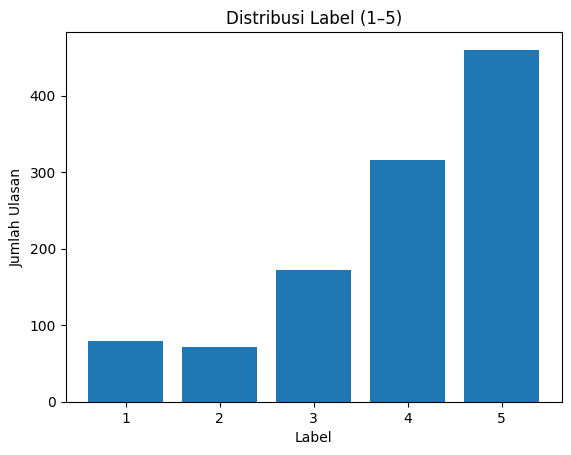

In [8]:
plt.figure()
plt.bar(label_counts.index.astype(str), label_counts.values)
plt.title(f"Distribusi Label ({'1–5'})")
plt.xlabel("Label")
plt.ylabel("Jumlah Ulasan")
plt.show()


In [9]:
df["char_len"] = df["text_basic"].str.len()
df["word_len"] = df["text_basic"].str.split().apply(len)

df[["char_len", "word_len"]].describe()


,char_len,word_len
count,1100.000000,1100.000000
mean,110.827273,20.051818
std,69.144698,12.977619
min,5.000000,1.000000
25%,62.000000,11.000000
50%,104.000000,19.000000
75%,147.000000,27.000000
max,914.000000,179.000000


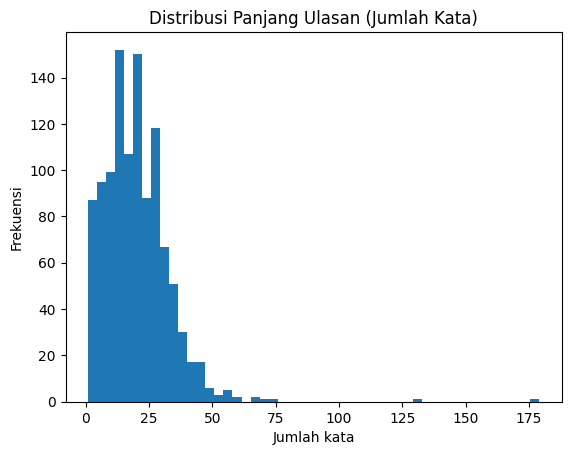

In [10]:
plt.figure()
plt.hist(df["word_len"], bins=50)
plt.title("Distribusi Panjang Ulasan (Jumlah Kata)")
plt.xlabel("Jumlah kata")
plt.ylabel("Frekuensi")
plt.show()


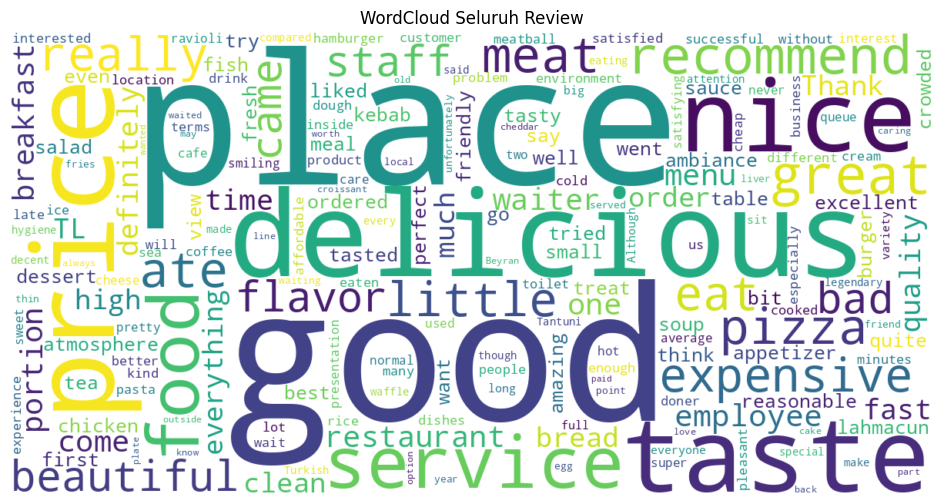

In [11]:
from wordcloud import WordCloud

all_text = " ".join(df["text_basic"].astype(str).tolist())

wc = WordCloud(width=1200, height=600, background_color="white", collocations=False).generate(all_text)

plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud Seluruh Review")
plt.show()


## 4. Train/Test Split


In [12]:
X = df["text_clean"].values
y = df["rating"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=SEED,
    stratify=y
)

print("Train:", len(X_train), "Test:", len(X_test))
print("Distribusi Train:", Counter(y_train))
print("Distribusi Test :", Counter(y_test))


Train: 880 Test: 220
Distribusi Train: Counter({5: 368, 4: 253, 3: 137, 1: 64, 2: 58})
Distribusi Test : Counter({5: 92, 4: 63, 3: 35, 1: 16, 2: 14})


## 5. Function Evaluasi


In [13]:
def eval_report(y_true, y_pred, title="Model"):
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    f1w = f1_score(y_true, y_pred, average="weighted")

    print(f"=== {title} ===")
    print("Accuracy :", round(acc, 4))
    print("F1-macro :", round(f1m, 4))
    print("F1-weight:", round(f1w, 4))
    print()
    print(classification_report(y_true, y_pred, digits=4, zero_division=0))
    print()
    return {"model": title, "accuracy": acc, "f1_macro": f1m, "f1_weighted": f1w}

def plot_confusion(y_true, y_pred, labels=None, title="Confusion Matrix"):
    if labels is None:
        labels = sorted(list(set(y_true) | set(y_pred)))
    cm = confusion_matrix(y_true, y_pred, labels=list(labels))

    plt.figure()
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()


## 6. Skenario 1 (Baseline TF‑IDF)


In [14]:
def fit_tfidf(train_texts, test_texts, max_features=50000, ngram_range=(1,2)):
    vec = TfidfVectorizer(
        lowercase=True,
        max_features=max_features,
        ngram_range=ngram_range
    )
    Xtr = vec.fit_transform(train_texts)
    Xte = vec.transform(test_texts)
    return vec, Xtr, Xte

In [15]:
results_s1 = []

### SVM


In [16]:
def train_eval_svm(train_texts, train_labels, test_texts, test_labels,
                   suffix="", class_weight=None, C=1.0,
                   max_features=50000, ngram_range=(1,2)):
    vec, Xtr, Xte = fit_tfidf(train_texts, test_texts, max_features, ngram_range)
    svm = LinearSVC(class_weight=class_weight, C=C)
    svm.fit(Xtr, train_labels)
    pred = svm.predict(Xte)
    res = eval_report(test_labels, pred, f"Linear SVM{suffix}")
    return res, vec, svm, pred


svm_s1_res, _, _, _ = train_eval_svm(
    X_train, y_train, X_test, y_test,
    suffix=" (S1 baseline)"
)
results_s1.append(svm_s1_res)


=== Linear SVM (S1 baseline) ===
Accuracy : 0.5
F1-macro : 0.3758
F1-weight: 0.4734

              precision    recall  f1-score   support

           1     0.5556    0.3125    0.4000        16
           2     0.3333    0.0714    0.1176        14
           3     0.3571    0.2857    0.3175        35
           4     0.3966    0.3651    0.3802        63
           5     0.5820    0.7717    0.6636        92

    accuracy                         0.5000       220
   macro avg     0.4449    0.3613    0.3758       220
weighted avg     0.4754    0.5000    0.4734       220




### NB


In [17]:
def train_eval_nb(train_texts, train_labels, test_texts, test_labels,
                  suffix="", max_features=50000, ngram_range=(1,2), alpha=1.0):
    vec, Xtr, Xte = fit_tfidf(train_texts, test_texts, max_features, ngram_range)
    nb = MultinomialNB(alpha=alpha)
    nb.fit(Xtr, train_labels)
    pred = nb.predict(Xte)
    res = eval_report(test_labels, pred, f"Naive Bayes{suffix}")
    return res, vec, nb, pred


nb_s1_res, _, _, _ = train_eval_nb(
    X_train, y_train, X_test, y_test,
    suffix=" (S1 baseline)"
)
results_s1.append(nb_s1_res)

=== Naive Bayes (S1 baseline) ===
Accuracy : 0.4364
F1-macro : 0.1479
F1-weight: 0.2912

              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000        16
           2     0.0000    0.0000    0.0000        14
           3     0.0000    0.0000    0.0000        35
           4     0.5000    0.0794    0.1370        63
           5     0.4333    0.9891    0.6026        92

    accuracy                         0.4364       220
   macro avg     0.1867    0.2137    0.1479       220
weighted avg     0.3244    0.4364    0.2912       220




### LR


In [18]:
def train_eval_lr(train_texts, train_labels, test_texts, test_labels,
                  suffix="", class_weight=None, C=1.0,
                  max_features=50000, ngram_range=(1,2)):
    vec, Xtr, Xte = fit_tfidf(train_texts, test_texts, max_features, ngram_range)

    lr = LogisticRegression(
        max_iter=2000,
        class_weight=class_weight,
        n_jobs=None,            # aman di Windows
        solver="saga",          # bagus utk sparse + multinomial
        multi_class="multinomial",
        C=C
    )
    lr.fit(Xtr, train_labels)
    pred = lr.predict(Xte)
    res = eval_report(test_labels, pred, f"Logistic Regression{suffix}")
    return res, vec, lr, pred


lr_s1_res, _, _, _ = train_eval_lr(
    X_train, y_train, X_test, y_test,
    suffix=" (S1 baseline)"
)
results_s1.append(lr_s1_res)


=== Logistic Regression (S1 baseline) ===
Accuracy : 0.4773
F1-macro : 0.2396
F1-weight: 0.4025

              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000        16
           2     0.0000    0.0000    0.0000        14
           3     0.4545    0.1429    0.2174        35
           4     0.3393    0.3016    0.3193        63
           5     0.5294    0.8804    0.6612        92

    accuracy                         0.4773       220
   macro avg     0.2646    0.2650    0.2396       220
weighted avg     0.3909    0.4773    0.4025       220




### Recap


In [19]:
s1_table = pd.DataFrame(results_s1)

from IPython.display import display

s1_best = (
    s1_table
    .sort_values("f1_macro", ascending=False)
    .drop_duplicates(subset=["model"], keep="first")
    .reset_index(drop=True)
)

display(s1_best)


,model,accuracy,f1_macro,f1_weighted
0,Linear SVM (S1 baseline),0.500000,0.375765,0.473433
1,Logistic Regression (S1 baseline),0.477273,0.239589,0.402541
2,Naive Bayes (S1 baseline),0.436364,0.147927,0.291245


## 7. Skenario 2 (Baseline Transformers (BERT & DistilBERT))


In [20]:
!pip install --upgrade datasets pyarrow pandas


In [ ]:
NUM_LABELS = 5
from datasets import Dataset
import evaluate

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
)

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

DEFAULT_MAX_LEN = 256 if HAS_GPU else 128
DEFAULT_BATCH = 8 if HAS_GPU else 2

# Max epoch besar + EarlyStopping biar fleksibel
DEFAULT_EPOCHS = 100 if HAS_GPU else 3

USE_SMALL_TRAIN_IF_CPU = True
SMALL_TRAIN_N = 2000

def make_hf_dataset(texts, labels):
    # label harus 0..num_labels-1
    return Dataset.from_dict({"text": list(texts), "label": [int(l) - 1 for l in labels]})

def make_tokenize_fn(tokenizer, max_length):
    def _tok(batch):
        return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=max_length)
    return _tok

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_metric.compute(predictions=preds, references=labels)["accuracy"]
    f1m = f1_metric.compute(predictions=preds, references=labels, average="macro")["f1"]
    f1w = f1_metric.compute(predictions=preds, references=labels, average="weighted")["f1"]
    return {"accuracy": acc, "f1_macro": f1m, "f1_weighted": f1w}

def maybe_shrink_train(train_texts, train_labels):
    if (not HAS_GPU) and USE_SMALL_TRAIN_IF_CPU and len(train_texts) > SMALL_TRAIN_N:
        return train_texts[:SMALL_TRAIN_N], train_labels[:SMALL_TRAIN_N]
    return train_texts, train_labels

def build_training_args(out_dir, epochs, batch_size):
    common = dict(
        output_dir=out_dir,
        save_strategy="epoch",
        evaluation_strategy="epoch",
        learning_rate=2e-5,
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1_macro", # bisa juga "eval_accuracy"
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=0.01,
        logging_steps=50,
        report_to="none",
        seed=SEED,
        fp16=HAS_GPU,
        dataloader_num_workers=0,
    )
    try:
        return TrainingArguments(**common)
    except TypeError:
        common.pop("evaluation_strategy", None)
        common["eval_strategy"] = "epoch"
        return TrainingArguments(**common)

class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        inputs = dict(inputs)
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        base_model = model.module if hasattr(model, "module") else model
        num_labels = base_model.config.num_labels

        if self.class_weights is not None:
            cw = self.class_weights.to(logits.device)
            loss_fct = torch.nn.CrossEntropyLoss(weight=cw)
        else:
            loss_fct = torch.nn.CrossEntropyLoss()

        loss = loss_fct(logits.view(-1, num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

def _build_trainer(model, args, train_tok, test_tok, tokenizer,
                   use_class_weights=False, class_weights=None):
    base_kwargs = dict(
        model=model,
        args=args,
        train_dataset=train_tok,
        eval_dataset=test_tok,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=1)],
    )

    cls = WeightedTrainer if use_class_weights else Trainer
    if use_class_weights:
        base_kwargs["class_weights"] = class_weights

    # tokenizer arg name changed in newer versions
    try:
        return cls(**base_kwargs, tokenizer=tokenizer)
    except TypeError:
        return cls(**base_kwargs, processing_class=tokenizer)

def safe_load_sequence_classifier(model_name, num_labels):
    try:
        return AutoModelForSequenceClassification.from_pretrained(
            model_name, num_labels=num_labels, use_safetensors=True
        )
    except Exception:
        pass
    try:
        return AutoModelForSequenceClassification.from_pretrained(
            model_name, num_labels=num_labels, use_safetensors=False
        )
    except Exception:
        pass
    return AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=num_labels
    )

def train_eval_transformer(
    model_name,
    train_texts, train_labels,
    test_texts, test_labels,
    epochs=DEFAULT_EPOCHS,
    batch_size=DEFAULT_BATCH,
    max_length=DEFAULT_MAX_LEN,
    out_dir="./tmp_tr",
    suffix="",
    use_class_weights=False
):
    train_texts2, train_labels2 = maybe_shrink_train(train_texts, train_labels)

    train_hf = make_hf_dataset(train_texts2, train_labels2)
    test_hf  = make_hf_dataset(test_texts, test_labels)

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = safe_load_sequence_classifier(model_name, num_labels=5)

    tok_fn = make_tokenize_fn(tokenizer, max_length=max_length)
    train_tok = train_hf.map(tok_fn, batched=True)
    test_tok  = test_hf.map(tok_fn, batched=True)

    train_tok = train_tok.remove_columns(["text"]).rename_column("label", "labels")
    test_tok  = test_tok.remove_columns(["text"]).rename_column("label", "labels")

    args = build_training_args(out_dir, epochs, batch_size)

    class_weights = None
    if use_class_weights:
        classes = np.arange(1, 5 + 1)
        cw = compute_class_weight(
            class_weight="balanced",
            classes=classes,
            y=np.array(train_labels2)
        )
        class_weights = torch.tensor(cw, dtype=torch.float)

    trainer = _build_trainer(
        model=model,
        args=args,
        train_tok=train_tok,
        test_tok=test_tok,
        tokenizer=tokenizer,
        use_class_weights=use_class_weights,
        class_weights=class_weights
    )

    trainer.train()
    res = trainer.evaluate()

    out = {
        "model": model_name + suffix,
        "accuracy": res.get("eval_accuracy"),
        "f1_macro": res.get("eval_f1_macro"),
        "f1_weighted": res.get("eval_f1_weighted"),
        "eval_loss": res.get("eval_loss"),
        "epoch": res.get("epoch"),
    }

    print(f"=== {model_name}{suffix} ===")
    print(res)
    print()
    return out


2025-12-10 04:17:27.723712: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765340247.746272    6584 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765340247.753077    6584 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [22]:
results_s2 = []

### BERT


In [23]:
try:
    bert_s2_res = train_eval_transformer(
        "bert-base-uncased",
        X_train, y_train, X_test, y_test,
        out_dir="./tmp_bert_s2",
        suffix=" (S2 baseline)",
        use_class_weights=False
    )
    results_s2.append(bert_s2_res)
except Exception as e:
    print("BERT S2 error:", e)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/880 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

/tmp/ipykernel_6584/2772586556.py:113: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  return cls(**base_kwargs, tokenizer=tokenizer)
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,1.451300,1.307374,0.413636,0.122565,0.252279
2,1.188400,1.090828,0.559091,0.317640,0.501875
3,0.919100,1.089665,0.531818,0.318317,0.499169
4,0.744200,1.197163,0.518182,0.351645,0.502506
5,0.595100,1.376944,0.536364,0.420316,0.533823
6,0.403000,1.524155,0.531818,0.368360,0.516706


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

=== bert-base-uncased (S2 baseline) ===
{'eval_loss': 1.3769440650939941, 'eval_accuracy': 0.5363636363636364, 'eval_f1_macro': 0.42031601590912604, 'eval_f1_weighted': 0.5338234801705715, 'eval_runtime': 2.3597, 'eval_samples_per_second': 93.23, 'eval_steps_per_second': 5.933, 'epoch': 6.0}



### DistilBERT


In [24]:
try:
    distil_s2_res = train_eval_transformer(
        "distilbert-base-uncased",
        X_train, y_train, X_test, y_test,
        out_dir="./tmp_distil_s2",
        suffix=" (S2 baseline)",
        use_class_weights=False
    )
    results_s2.append(distil_s2_res)
except Exception as e:
    print("DistilBERT S2 error:", e)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/880 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

/tmp/ipykernel_6584/2772586556.py:113: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  return cls(**base_kwargs, tokenizer=tokenizer)
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,1.418200,1.284437,0.422727,0.124864,0.257022
2,1.226700,1.142215,0.504545,0.268894,0.438868
3,1.020200,1.080730,0.531818,0.324826,0.492387
4,0.874300,1.119390,0.540909,0.384541,0.523294
5,0.759500,1.188161,0.545455,0.384272,0.524120


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

=== distilbert-base-uncased (S2 baseline) ===
{'eval_loss': 1.1193897724151611, 'eval_accuracy': 0.5409090909090909, 'eval_f1_macro': 0.38454085793081416, 'eval_f1_weighted': 0.5232943531368534, 'eval_runtime': 1.1442, 'eval_samples_per_second': 192.267, 'eval_steps_per_second': 12.235, 'epoch': 5.0}



### Recap


In [25]:
s2_table = pd.DataFrame(results_s2)
s2_best = (
    s2_table
    .sort_values("f1_macro", ascending=False)
    .drop_duplicates(subset=["model"], keep="first")
    .reset_index(drop=True)
)

display(s2_best)


,model,accuracy,f1_macro,f1_weighted,eval_loss,epoch
0,bert-base-uncased (S2 baseline),0.536364,0.420316,0.533823,1.376944,6.0
1,distilbert-base-uncased (S2 baseline),0.540909,0.384541,0.523294,1.119390,5.0


## 8. Skenario 3 — Augmentasi


In [26]:
# Cara aman: split ulang index-based
idx = np.arange(len(df))
train_idx, test_idx = train_test_split(
    idx,
    test_size=0.2,
    random_state=SEED,
    stratify=df["rating"].values
)

df_train = df.iloc[train_idx].copy()
df_test  = df.iloc[test_idx].copy()

X_train_basic = df_train["text_basic"].values
y_train_s3    = df_train["rating"].values

X_test_clean  = df_test["text_clean"].values
y_test_s3     = df_test["rating"].values

print("S3 Train size:", len(X_train_basic))
print("S3 Test size :", len(X_test_clean))
print("Distribusi S3 train:", Counter(y_train_s3))
print("Distribusi S3 test :", Counter(y_test_s3))


S3 Train size: 880
S3 Test size : 220
Distribusi S3 train: Counter({5: 368, 4: 253, 3: 137, 1: 64, 2: 58})
Distribusi S3 test : Counter({5: 92, 4: 63, 3: 35, 1: 16, 2: 14})


In [27]:
def get_synonyms(word):
    syns = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            w = lemma.name().replace("_", " ").lower()
            if w != word.lower():
                syns.add(w)
    return list(syns)

def random_deletion(words, p=0.1):
    if len(words) <= 1:
        return words
    new_words = [w for w in words if random.random() > p]
    return new_words if new_words else [random.choice(words)]

def random_swap(words, n=1):
    new_words = words[:]
    for _ in range(n):
        if len(new_words) < 2:
            break
        i, j = random.sample(range(len(new_words)), 2)
        new_words[i], new_words[j] = new_words[j], new_words[i]
    return new_words

def random_insertion(words, n=1):
    new_words = words[:]
    for _ in range(n):
        if not new_words:
            break
        w = random.choice(new_words)
        syns = get_synonyms(w)
        if not syns:
            continue
        new_words.insert(random.randint(0, len(new_words)), random.choice(syns))
    return new_words

def synonym_replacement(words, n=1):
    new_words = words[:]
    candidates = [w for w in set(words) if get_synonyms(w)]
    random.shuffle(candidates)
    num_replaced = 0
    for w in candidates:
        syns = get_synonyms(w)
        if not syns:
            continue
        new_words = [random.choice(syns) if x == w else x for x in new_words]
        num_replaced += 1
        if num_replaced >= n:
            break
    return new_words

In [28]:
def eda(text, alpha=0.1, num_aug=1):
    words = str(text).split()
    if not words:
        return [str(text)] * num_aug
    n = max(1, int(alpha * len(words)))
    augmented = []
    for _ in range(num_aug):
        choice = random.choice(["sr", "ri", "rs", "rd"])
        if choice == "sr":
            w = synonym_replacement(words, n)
        elif choice == "ri":
            w = random_insertion(words, n)
        elif choice == "rs":
            w = random_swap(words, n)
        else:
            w = random_deletion(words, p=alpha)
        augmented.append(" ".join(w))
    return augmented

def modified_eda(text, alpha=0.05, num_aug=1):
    return eda(text, alpha=alpha, num_aug=num_aug)


In [29]:
_BERT_AUG = None

def get_bert_aug():
    global _BERT_AUG
    if _BERT_AUG is not None:
        return _BERT_AUG

    import nlpaug.augmenter.word as naw
    device = "cuda" if torch.cuda.is_available() else "cpu"

    try:
        _BERT_AUG = naw.ContextualWordEmbsAug(
            model_path="bert-base-uncased",
            action="substitute",
            device=device
        )
    except TypeError:
        # fallback untuk versi nlpaug lama
        _BERT_AUG = naw.ContextualWordEmbsAug(
            model_path="bert-base-uncased",
            action="substitute"
        )
    return _BERT_AUG

def bert_augment(text, num_aug=1):
    try:
        aug = get_bert_aug()
        out = aug.augment(text, n=num_aug)
        if isinstance(out, str):
            out = [out]
        return out
    except Exception:
        return [text] * num_aug


In [30]:
_BT_CACHE = {}

def get_bt_models(src_lang="en", mid_lang="fr"):
    key = (src_lang, mid_lang)
    if key in _BT_CACHE:
        return _BT_CACHE[key]

    from transformers import MarianMTModel, MarianTokenizer

    model_name_1 = f"Helsinki-NLP/opus-mt-{src_lang}-{mid_lang}"
    model_name_2 = f"Helsinki-NLP/opus-mt-{mid_lang}-{src_lang}"

    tok1 = MarianTokenizer.from_pretrained(model_name_1)
    mod1 = MarianMTModel.from_pretrained(model_name_1)
    tok2 = MarianTokenizer.from_pretrained(model_name_2)
    mod2 = MarianMTModel.from_pretrained(model_name_2)

    if torch.cuda.is_available():
        mod1 = mod1.to("cuda")
        mod2 = mod2.to("cuda")

    _BT_CACHE[key] = (tok1, mod1, tok2, mod2)
    return _BT_CACHE[key]

def _translate_one(text, tok, mod, max_length=256):
    dev = next(mod.parameters()).device
    batch = tok([text], return_tensors="pt", truncation=True, padding=True)
    batch = {k: v.to(dev) for k, v in batch.items()}
    gen = mod.generate(**batch, max_length=max_length)
    return tok.batch_decode(gen, skip_special_tokens=True)[0]

def backtranslate(text, src_lang="en", mid_lang="fr"):
    try:
        tok1, mod1, tok2, mod2 = get_bt_models(src_lang, mid_lang)
        mid = _translate_one(text, tok1, mod1)
        back = _translate_one(mid, tok2, mod2)
        return back
    except Exception:
        return text


In [31]:
def augment_minority(
    texts, labels,
    strategy="eda",
    target_multiplier=1.0,
    max_aug_per_sample=1
):
    texts = list(texts)
    labels = list(labels)

    counts = Counter(labels)
    max_count = max(counts.values())
    target_count = int(max_count * target_multiplier)

    new_texts = texts[:]
    new_labels = labels[:]

    idx_by_class = {c: [] for c in counts}
    for i, lab in enumerate(labels):
        idx_by_class[lab].append(i)

    for c, idxs in idx_by_class.items():
        need = max(0, target_count - counts[c])
        if need == 0:
            continue

        pool = idxs[:]
        random.shuffle(pool)
        ptr = 0

        while need > 0 and pool:
            i = pool[ptr % len(pool)]
            base = texts[i]
            k = min(max_aug_per_sample, need)

            if strategy == "eda":
                aug_texts = eda(base, alpha=0.1, num_aug=k)
            elif strategy == "modified_eda":
                aug_texts = modified_eda(base, alpha=0.05, num_aug=k)
            elif strategy == "bert":
                aug_texts = bert_augment(base, num_aug=k)
            elif strategy == "backtranslation":
                aug_texts = [backtranslate(base) for _ in range(k)]
            else:
                aug_texts = []

            for t in aug_texts:
                if need <= 0:
                    break
                new_texts.append(t)
                new_labels.append(c)
                need -= 1

            ptr += 1

    return np.array(new_texts), np.array(new_labels)


Save Output


In [32]:
AUG_OUT_DIR = "./aug_outputs"
os.makedirs(AUG_OUT_DIR, exist_ok=True)

AUG_STRATEGIES = ["eda", "modified_eda", "bert", "backtranslation"]

TARGET_MULTIPLIER = 1.0
MAX_AUG_PER_SAMPLE = 1   

print("Distribusi train original:", Counter(y_train_s3))
print("AUG_STRATEGIES:", AUG_STRATEGIES)

def post_clean_texts(texts):
    return [lemmatize_text(t) for t in texts]

def build_aug_dataframe(strategy):
    Xa, ya = augment_minority(
        X_train_basic, y_train_s3,
        strategy=strategy,
        target_multiplier=TARGET_MULTIPLIER,
        max_aug_per_sample=MAX_AUG_PER_SAMPLE
    )

    Xa_clean = post_clean_texts(Xa)

    df_aug = pd.DataFrame({
        "text_basic_aug": Xa,
        "text_clean_aug": Xa_clean,
        "label": ya
    })
    return df_aug

def save_aug_csv(strategy):
    df_aug = build_aug_dataframe(strategy)
    out_path = os.path.join(AUG_OUT_DIR, f"train_aug_{strategy}.csv")
    df_aug.to_csv(out_path, index=False)
    print(f"Saved: {out_path} | shape={df_aug.shape} | dist={Counter(df_aug['label'])}")
    return out_path

AUG_PATHS = {}
for strat in AUG_STRATEGIES:
    try:
        AUG_PATHS[strat] = save_aug_csv(strat)
    except Exception as e:
        print("Aug error:", strat, e)

AUG_PATHS


Distribusi train original: Counter({5: 368, 4: 253, 3: 137, 1: 64, 2: 58})
AUG_STRATEGIES: ['eda', 'modified_eda', 'bert', 'backtranslation']
Saved: ./aug_outputs/train_aug_eda.csv | shape=(1840, 3) | dist=Counter({4: 368, 5: 368, 2: 368, 3: 368, 1: 368})
Saved: ./aug_outputs/train_aug_modified_eda.csv | shape=(1840, 3) | dist=Counter({4: 368, 5: 368, 2: 368, 3: 368, 1: 368})


The following layers were not sharded: cls.predictions.transform.LayerNorm.weight, bert.encoder.layer.*.intermediate.dense.weight, cls.predictions.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.token_type_embeddings.weight, cls.predictions.transform.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.weight, cls.predictions.decoder.bias, cls.predictions.transform.dense.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.query.weight, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.intermediate.dense.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.output.dense.bias, cls.predictions.decoder.weight, bert.encoder.layer.*.attention.self.key.bias, bert.embeddings.word_embeddings.weight, bert.embeddings.LayerNorm.weight, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.la

Saved: ./aug_outputs/train_aug_bert.csv | shape=(1840, 3) | dist=Counter({4: 368, 5: 368, 2: 368, 3: 368, 1: 368})


The following layers were not sharded: model.encoder.layers.*.self_attn_layer_norm.weight, model.decoder.layers.*.self_attn.out_proj.bias, model.encoder.layers.*.final_layer_norm.bias, model.decoder.layers.*.encoder_attn.q_proj.bias, model.decoder.layers.*.encoder_attn.out_proj.weight, model.encoder.embed_positions.weight, model.decoder.layers.*.self_attn.v_proj.weight, model.decoder.layers.*.self_attn.q_proj.bias, model.decoder.layers.*.self_attn.k_proj.weight, model.decoder.layers.*.encoder_attn.k_proj.bias, model.decoder.layers.*.fc*.weight, model.encoder.layers.*.self_attn.q_proj.bias, model.decoder.layers.*.encoder_attn_layer_norm.weight, model.decoder.layers.*.final_layer_norm.bias, model.encoder.layers.*.self_attn.v_proj.weight, model.encoder.layers.*.self_attn.v_proj.bias, model.decoder.layers.*.self_attn.q_proj.weight, model.encoder.embed_tokens.weight, model.decoder.embed_positions.weight, model.decoder.layers.*.encoder_attn.q_proj.weight, model.decoder.layers.*.self_attn.k_p

Saved: ./aug_outputs/train_aug_backtranslation.csv | shape=(1840, 3) | dist=Counter({4: 368, 5: 368, 2: 368, 3: 368, 1: 368})


{'eda': './aug_outputs/train_aug_eda.csv',
 'modified_eda': './aug_outputs/train_aug_modified_eda.csv',
 'bert': './aug_outputs/train_aug_bert.csv',
 'backtranslation': './aug_outputs/train_aug_backtranslation.csv'}

### Contoh Sample


In [33]:
def show_aug_examples(sample_text=None):
    if sample_text is None:
        sample_text = random.choice(list(X_train_basic))

    rows = []
    rows.append(("original (basic)", sample_text))
    rows.append(("original (clean)", lemmatize_text(sample_text)))

    # Show one example each operation family using EDA/Modified EDA
    rows.append(("EDA sr/ri/rs/rd (1 sample)", eda(sample_text, alpha=0.1, num_aug=1)[0]))
    rows.append(("Modified EDA (1 sample)", modified_eda(sample_text, alpha=0.05, num_aug=1)[0]))

    # BERT aug
    rows.append(("BERT aug (1 sample)", bert_augment(sample_text, num_aug=1)[0]))

    # Backtranslation
    rows.append(("Backtranslation (1 sample)", backtranslate(sample_text)))

    ex = pd.DataFrame(rows, columns=["method", "sentence"])
    return ex

example_df = show_aug_examples()

print("\n=== FULL SENTENCES ===")
for method, sentence in example_df.itertuples(index=False):
    print(f"[{method}]")
    print(sentence)
    print("-" * 80)



=== FULL SENTENCES ===
[original (basic)]
The pickles that came after you placed your order were very nice. Tantuni is not bad; you can try it. But I would say it's a little oily.
--------------------------------------------------------------------------------
[original (clean)]
the pickle that come after you place your order be very nice tantuni be not bad you can try it but i would say it s a little oily
--------------------------------------------------------------------------------
[EDA sr/ri/rs/rd (1 sample)]
The pickles that came after you placed your order very nice. Tantuni is not bad; you can try But I would say it's a little oily.
--------------------------------------------------------------------------------
[Modified EDA (1 sample)]
The pickles that came after you placed your order very nice. Tantuni is not bad; can try it. But I would say it's a little oily.
--------------------------------------------------------------------------------
[BERT aug (1 sample)]
those pickl

In [34]:
def load_aug(strategy):
    path = os.path.join(AUG_OUT_DIR, f"train_aug_{strategy}.csv")
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    df_aug = pd.read_csv(path)
    Xtr = df_aug["text_clean_aug"].astype(str).values
    ytr = df_aug["label"].astype(int).values
    return Xtr, ytr, df_aug

# test set clean labels
X_test_s3 = X_test_clean
y_test_s3 = y_test_s3

print("Test dist (S3):", Counter(y_test_s3))


Test dist (S3): Counter({5: 92, 4: 63, 3: 35, 1: 16, 2: 14})


In [35]:
results_s3 = []

### TFIDF


In [36]:
for strat in AUG_STRATEGIES:
    print("\n" + "-"*60)
    print("S3 | TF-IDF models | Strategy:", strat)

    try:
        Xtr_aug, ytr_aug, _ = load_aug(strat)
        print("Train dist:", Counter(ytr_aug))

        # SVM
        svm_res, _, _, _ = train_eval_svm(
            Xtr_aug, ytr_aug, X_test_s3, y_test_s3,
            suffix=f" (S3 aug={strat})"
        )
        results_s3.append(svm_res)

        # NB
        nb_res, _, _, _ = train_eval_nb(
            Xtr_aug, ytr_aug, X_test_s3, y_test_s3,
            suffix=f" (S3 aug={strat})"
        )
        results_s3.append(nb_res)

        # LR
        lr_res, _, _, _ = train_eval_lr(
            Xtr_aug, ytr_aug, X_test_s3, y_test_s3,
            suffix=f" (S3 aug={strat})"
        )
        results_s3.append(lr_res)

    except Exception as e:
        print("S3 TF-IDF error:", strat, e)

s3_tfidf_table = pd.DataFrame(results_s3)
s3_tfidf_table



------------------------------------------------------------
S3 | TF-IDF models | Strategy: eda
Train dist: Counter({4: 368, 5: 368, 2: 368, 3: 368, 1: 368})
=== Linear SVM (S3 aug=eda) ===
Accuracy : 0.4727
F1-macro : 0.3751
F1-weight: 0.4649

              precision    recall  f1-score   support

           1     0.4545    0.3125    0.3704        16
           2     0.1818    0.1429    0.1600        14
           3     0.3333    0.3429    0.3380        35
           4     0.3667    0.3492    0.3577        63
           5     0.6176    0.6848    0.6495        92

    accuracy                         0.4727       220
   macro avg     0.3908    0.3664    0.3751       220
weighted avg     0.4609    0.4727    0.4649       220


=== Naive Bayes (S3 aug=eda) ===
Accuracy : 0.4727
F1-macro : 0.4053
F1-weight: 0.4831

              precision    recall  f1-score   support

           1     0.5455    0.3750    0.4444        16
           2     0.1515    0.3571    0.2128        14
           3 

,model,accuracy,f1_macro,f1_weighted
0,Linear SVM (S3 aug=eda),0.472727,0.375121,0.464937
1,Naive Bayes (S3 aug=eda),0.472727,0.405282,0.483077
2,Logistic Regression (S3 aug=eda),0.472727,0.370317,0.473298
3,Linear SVM (S3 aug=modified_eda),0.468182,0.380895,0.460067
4,Naive Bayes (S3 aug=modified_eda),0.463636,0.406881,0.477030
5,Logistic Regression (S3 aug=modified_eda),0.477273,0.383209,0.478697
6,Linear SVM (S3 aug=bert),0.440909,0.372659,0.437744
7,Naive Bayes (S3 aug=bert),0.445455,0.369150,0.439468
8,Logistic Regression (S3 aug=bert),0.450000,0.374484,0.444189
9,Linear SVM (S3 aug=backtranslation),0.459091,0.373903,0.453903


### Transformer


In [37]:
def clean_tmp(prefix="./tmp_"):
    for d in glob.glob(prefix + "*"):
        shutil.rmtree(d, ignore_errors=True)

results_s3_tr = []

for strat in AUG_STRATEGIES:
    print("\n" + "-"*60)
    print("S3 | Transformers | Strategy:", strat)
    clean_tmp()

    try:
        Xtr_aug, ytr_aug, _ = load_aug(strat)
        print("Train dist:", Counter(ytr_aug))

        # BERT
        bert_res = train_eval_transformer(
            "bert-base-uncased",
            Xtr_aug, ytr_aug, X_test_s3, y_test_s3,
            out_dir=f"./tmp_bert_s3_{strat}",
            suffix=f" (S3 aug={strat})",
            use_class_weights=True
        )
        results_s3_tr.append(bert_res)

        # DistilBERT
        distil_res = train_eval_transformer(
            "distilbert-base-uncased",
            Xtr_aug, ytr_aug, X_test_s3, y_test_s3,
            out_dir=f"./tmp_distil_s3_{strat}",
            suffix=f" (S3 aug={strat})",
            use_class_weights=True
        )
        results_s3_tr.append(distil_res)

    except Exception as e:
        print("S3 Transformer error:", strat, e)

s3_tr_table = pd.DataFrame(results_s3_tr)
s3_tr_table



------------------------------------------------------------
S3 | Transformers | Strategy: eda
Train dist: Counter({4: 368, 5: 368, 2: 368, 3: 368, 1: 368})


The following layers were not sharded: bert.pooler.dense.bias, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.token_type_embeddings.weight, bert.pooler.dense.weight, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.query.weight, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.intermediate.dense.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.key.bias, bert.embeddings.word_embeddings.weight, bert.embeddings.LayerNorm.weight, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.attention.self.key.weight, classifier.weight, bert.encoder.layer.*.output.LayerNorm

Map:   0%|          | 0/1840 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

/tmp/ipykernel_6584/2772586556.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,1.331300,1.122800,0.486364,0.377319,0.484027
2,0.748800,1.252877,0.518182,0.382241,0.480853
3,0.439800,1.325081,0.563636,0.476050,0.552760
4,0.198600,1.489199,0.559091,0.462095,0.555360


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


=== bert-base-uncased (S3 aug=eda) ===
{'eval_loss': 1.3250811100006104, 'eval_accuracy': 0.5636363636363636, 'eval_f1_macro': 0.47605046521881833, 'eval_f1_weighted': 0.552759510906459, 'eval_runtime': 2.3622, 'eval_samples_per_second': 93.134, 'eval_steps_per_second': 5.927, 'epoch': 4.0}



The following layers were not sharded: distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.embeddings.position_embeddings.weight, pre_classifier.weight, distilbert.transformer.layer.*.ffn.lin*.bias, distilbert.embeddings.word_embeddings.weight, pre_classifier.bias, classifier.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.embeddings.LayerNorm.bias, classifier.weight, distilbert.embeddings.LayerNorm.weight, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.trans

Map:   0%|          | 0/1840 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

/tmp/ipykernel_6584/2772586556.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,1.316600,1.187380,0.440909,0.356055,0.434877
2,0.846900,1.134219,0.531818,0.445806,0.529768
3,0.552900,1.287923,0.472727,0.414705,0.479544


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


=== distilbert-base-uncased (S3 aug=eda) ===
{'eval_loss': 1.1342188119888306, 'eval_accuracy': 0.5318181818181819, 'eval_f1_macro': 0.44580602006688963, 'eval_f1_weighted': 0.5297677105503192, 'eval_runtime': 1.1495, 'eval_samples_per_second': 191.396, 'eval_steps_per_second': 12.18, 'epoch': 3.0}


------------------------------------------------------------
S3 | Transformers | Strategy: modified_eda
Train dist: Counter({4: 368, 5: 368, 2: 368, 3: 368, 1: 368})


The following layers were not sharded: bert.pooler.dense.bias, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.token_type_embeddings.weight, bert.pooler.dense.weight, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.query.weight, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.intermediate.dense.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.key.bias, bert.embeddings.word_embeddings.weight, bert.embeddings.LayerNorm.weight, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.attention.self.key.weight, classifier.weight, bert.encoder.layer.*.output.LayerNorm

Map:   0%|          | 0/1840 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

/tmp/ipykernel_6584/2772586556.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,1.217400,1.207271,0.400000,0.356922,0.399882
2,0.713500,1.214526,0.540909,0.375052,0.502462
3,0.422100,1.448831,0.486364,0.374421,0.472189


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


=== bert-base-uncased (S3 aug=modified_eda) ===
{'eval_loss': 1.214525580406189, 'eval_accuracy': 0.5409090909090909, 'eval_f1_macro': 0.3750522909647872, 'eval_f1_weighted': 0.5024621676486444, 'eval_runtime': 2.3621, 'eval_samples_per_second': 93.138, 'eval_steps_per_second': 5.927, 'epoch': 3.0}



The following layers were not sharded: distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.embeddings.position_embeddings.weight, pre_classifier.weight, distilbert.transformer.layer.*.ffn.lin*.bias, distilbert.embeddings.word_embeddings.weight, pre_classifier.bias, classifier.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.embeddings.LayerNorm.bias, classifier.weight, distilbert.embeddings.LayerNorm.weight, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.trans

Map:   0%|          | 0/1840 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

/tmp/ipykernel_6584/2772586556.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,1.240400,1.226245,0.418182,0.341639,0.429951
2,0.769600,1.182725,0.518182,0.415016,0.518361
3,0.514000,1.358881,0.504545,0.414934,0.510162


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


=== distilbert-base-uncased (S3 aug=modified_eda) ===
{'eval_loss': 1.1827248334884644, 'eval_accuracy': 0.5181818181818182, 'eval_f1_macro': 0.4150164120688132, 'eval_f1_weighted': 0.518360649274606, 'eval_runtime': 1.1422, 'eval_samples_per_second': 192.603, 'eval_steps_per_second': 12.257, 'epoch': 3.0}


------------------------------------------------------------
S3 | Transformers | Strategy: bert
Train dist: Counter({4: 368, 5: 368, 2: 368, 3: 368, 1: 368})


The following layers were not sharded: bert.pooler.dense.bias, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.token_type_embeddings.weight, bert.pooler.dense.weight, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.query.weight, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.intermediate.dense.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.key.bias, bert.embeddings.word_embeddings.weight, bert.embeddings.LayerNorm.weight, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.attention.self.key.weight, classifier.weight, bert.encoder.layer.*.output.LayerNorm

Map:   0%|          | 0/1840 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

/tmp/ipykernel_6584/2772586556.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,1.384200,1.236302,0.486364,0.347210,0.442112
2,1.083100,1.142363,0.490909,0.305681,0.445698


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


=== bert-base-uncased (S3 aug=bert) ===
{'eval_loss': 1.2363016605377197, 'eval_accuracy': 0.4863636363636364, 'eval_f1_macro': 0.34721030247564455, 'eval_f1_weighted': 0.4421123245814335, 'eval_runtime': 2.3673, 'eval_samples_per_second': 92.933, 'eval_steps_per_second': 5.914, 'epoch': 2.0}



The following layers were not sharded: distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.embeddings.position_embeddings.weight, pre_classifier.weight, distilbert.transformer.layer.*.ffn.lin*.bias, distilbert.embeddings.word_embeddings.weight, pre_classifier.bias, classifier.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.embeddings.LayerNorm.bias, classifier.weight, distilbert.embeddings.LayerNorm.weight, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.trans

Map:   0%|          | 0/1840 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

/tmp/ipykernel_6584/2772586556.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,1.321200,1.260054,0.409091,0.368350,0.402347
2,1.076900,1.145506,0.527273,0.381640,0.520333
3,0.751100,1.266814,0.509091,0.419016,0.512371
4,0.476200,1.379570,0.500000,0.389959,0.498471


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


=== distilbert-base-uncased (S3 aug=bert) ===
{'eval_loss': 1.266814112663269, 'eval_accuracy': 0.509090909090909, 'eval_f1_macro': 0.41901609501609505, 'eval_f1_weighted': 0.5123707000070636, 'eval_runtime': 1.1472, 'eval_samples_per_second': 191.767, 'eval_steps_per_second': 12.203, 'epoch': 4.0}


------------------------------------------------------------
S3 | Transformers | Strategy: backtranslation
Train dist: Counter({4: 368, 5: 368, 2: 368, 3: 368, 1: 368})


The following layers were not sharded: bert.pooler.dense.bias, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.embeddings.token_type_embeddings.weight, bert.pooler.dense.weight, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.query.weight, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.intermediate.dense.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.key.bias, bert.embeddings.word_embeddings.weight, bert.embeddings.LayerNorm.weight, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.attention.self.key.weight, classifier.weight, bert.encoder.layer.*.output.LayerNorm

Map:   0%|          | 0/1840 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

/tmp/ipykernel_6584/2772586556.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,1.152500,1.263256,0.409091,0.365244,0.398468
2,0.645100,1.211754,0.563636,0.400881,0.552043
3,0.388700,1.390474,0.545455,0.389246,0.521070


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


=== bert-base-uncased (S3 aug=backtranslation) ===
{'eval_loss': 1.2117537260055542, 'eval_accuracy': 0.5636363636363636, 'eval_f1_macro': 0.40088108759720464, 'eval_f1_weighted': 0.5520430072295813, 'eval_runtime': 2.3718, 'eval_samples_per_second': 92.757, 'eval_steps_per_second': 5.903, 'epoch': 3.0}



The following layers were not sharded: distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.attention.out_lin.bias, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.output_layer_norm.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.transformer.layer.*.attention.q_lin.bias, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.embeddings.position_embeddings.weight, pre_classifier.weight, distilbert.transformer.layer.*.ffn.lin*.bias, distilbert.embeddings.word_embeddings.weight, pre_classifier.bias, classifier.bias, distilbert.transformer.layer.*.sa_layer_norm.weight, distilbert.embeddings.LayerNorm.bias, classifier.weight, distilbert.embeddings.LayerNorm.weight, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.transformer.layer.*.ffn.lin*.weight, distilbert.transformer.layer.*.sa_layer_norm.bias, distilbert.trans

Map:   0%|          | 0/1840 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

/tmp/ipykernel_6584/2772586556.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,1.207000,1.195706,0.454545,0.389092,0.462217
2,0.737900,1.170164,0.554545,0.446246,0.555131
3,0.504100,1.303443,0.500000,0.387324,0.505263


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


=== distilbert-base-uncased (S3 aug=backtranslation) ===
{'eval_loss': 1.1701635122299194, 'eval_accuracy': 0.5545454545454546, 'eval_f1_macro': 0.4462461834840351, 'eval_f1_weighted': 0.5551307794739555, 'eval_runtime': 1.1434, 'eval_samples_per_second': 192.416, 'eval_steps_per_second': 12.245, 'epoch': 3.0}



,model,accuracy,f1_macro,f1_weighted,eval_loss,epoch
0,bert-base-uncased (S3 aug=eda),0.563636,0.476050,0.552760,1.325081,4.0
1,distilbert-base-uncased (S3 aug=eda),0.531818,0.445806,0.529768,1.134219,3.0
2,bert-base-uncased (S3 aug=modified_eda),0.540909,0.375052,0.502462,1.214526,3.0
3,distilbert-base-uncased (S3 aug=modified_eda),0.518182,0.415016,0.518361,1.182725,3.0
4,bert-base-uncased (S3 aug=bert),0.486364,0.347210,0.442112,1.236302,2.0
5,distilbert-base-uncased (S3 aug=bert),0.509091,0.419016,0.512371,1.266814,4.0
6,bert-base-uncased (S3 aug=backtranslation),0.563636,0.400881,0.552043,1.211754,3.0
7,distilbert-base-uncased (S3 aug=backtranslation),0.554545,0.446246,0.555131,1.170164,3.0


# Summary


In [38]:
# Gabungkan S3 results
s3_table = pd.concat([s3_tfidf_table, s3_tr_table], ignore_index=True) if (len(results_s3) or len(results_s3_tr)) else pd.DataFrame()

def pick_cols(df_):
    cols = ["model", "accuracy", "f1_macro", "f1_weighted"]
    if "eval_loss" in df_.columns:
        cols.append("eval_loss")
    if "epoch" in df_.columns:
        cols.append("epoch")
    return df_[cols].copy()

s1_clean = pick_cols(s1_table) if "s1_table" in globals() else pd.DataFrame()
s2_clean = pick_cols(s2_table) if "s2_table" in globals() else pd.DataFrame()
s3_clean = pick_cols(s3_table) if not s3_table.empty else pd.DataFrame()

print("S1 (TF-IDF baseline):")
display(s1_clean.sort_values("f1_macro", ascending=False) if not s1_clean.empty else s1_clean)

print("\nS2 (Transformer baseline):")
display(s2_clean.sort_values("f1_macro", ascending=False) if not s2_clean.empty else s2_clean)

print("\nS3 (Aug from CSV):")
display(s3_clean.sort_values("f1_macro", ascending=False) if not s3_clean.empty else s3_clean)

summary = pd.concat([s1_clean, s2_clean, s3_clean], ignore_index=True) if not (s1_clean.empty and s2_clean.empty and s3_clean.empty) else pd.DataFrame()
summary = summary.sort_values("f1_macro", ascending=False) if not summary.empty else summary

print("\nSUMMARY (sorted by f1_macro):")
display(summary)


S1 (TF-IDF baseline):


,model,accuracy,f1_macro,f1_weighted
0,Linear SVM (S1 baseline),0.500000,0.375765,0.473433
2,Logistic Regression (S1 baseline),0.477273,0.239589,0.402541
1,Naive Bayes (S1 baseline),0.436364,0.147927,0.291245



S2 (Transformer baseline):


,model,accuracy,f1_macro,f1_weighted,eval_loss,epoch
0,bert-base-uncased (S2 baseline),0.536364,0.420316,0.533823,1.376944,6.0
1,distilbert-base-uncased (S2 baseline),0.540909,0.384541,0.523294,1.119390,5.0



S3 (Aug from CSV):


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,model,accuracy,f1_macro,f1_weighted,eval_loss,epoch
12,bert-base-uncased (S3 aug=eda),0.563636,0.476050,0.552760,1.325081,4.0
19,distilbert-base-uncased (S3 aug=backtranslation),0.554545,0.446246,0.555131,1.170164,3.0
13,distilbert-base-uncased (S3 aug=eda),0.531818,0.445806,0.529768,1.134219,3.0
17,distilbert-base-uncased (S3 aug=bert),0.509091,0.419016,0.512371,1.266814,4.0
15,distilbert-base-uncased (S3 aug=modified_eda),0.518182,0.415016,0.518361,1.182725,3.0
4,Naive Bayes (S3 aug=modified_eda),0.463636,0.406881,0.477030,NaN,NaN
1,Naive Bayes (S3 aug=eda),0.472727,0.405282,0.483077,NaN,NaN
18,bert-base-uncased (S3 aug=backtranslation),0.563636,0.400881,0.552043,1.211754,3.0
5,Logistic Regression (S3 aug=modified_eda),0.477273,0.383209,0.478697,NaN,NaN
11,Logistic Regression (S3 aug=backtranslation),0.486364,0.381717,0.481611,NaN,NaN



SUMMARY (sorted by f1_macro):


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,model,accuracy,f1_macro,f1_weighted,eval_loss,epoch
17,bert-base-uncased (S3 aug=eda),0.563636,0.476050,0.552760,1.325081,4.0
24,distilbert-base-uncased (S3 aug=backtranslation),0.554545,0.446246,0.555131,1.170164,3.0
18,distilbert-base-uncased (S3 aug=eda),0.531818,0.445806,0.529768,1.134219,3.0
3,bert-base-uncased (S2 baseline),0.536364,0.420316,0.533823,1.376944,6.0
22,distilbert-base-uncased (S3 aug=bert),0.509091,0.419016,0.512371,1.266814,4.0
20,distilbert-base-uncased (S3 aug=modified_eda),0.518182,0.415016,0.518361,1.182725,3.0
9,Naive Bayes (S3 aug=modified_eda),0.463636,0.406881,0.477030,NaN,NaN
6,Naive Bayes (S3 aug=eda),0.472727,0.405282,0.483077,NaN,NaN
23,bert-base-uncased (S3 aug=backtranslation),0.563636,0.400881,0.552043,1.211754,3.0
4,distilbert-base-uncased (S2 baseline),0.540909,0.384541,0.523294,1.119390,5.0
